# FFDI Difference

code is setup to compute the change in FFDI from the GWL 1.2 using the Zarr for each RCM


In [1]:
import sys
import os

import intake
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

import warnings
warnings.filterwarnings('ignore')
client = Client()
client

2024-07-26 18:37:12,582 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-07-26 18:37:12,586 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-07-26 18:37:12,591 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46437,Workers: 48
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40879,Total threads: 1
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/35225/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44535,


2024-07-26 18:57:22,801 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-FFDI-3880cf71a8e9ff8f7ee771dc4775a56f' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x148d722e7ac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x148a36aca780>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x148d722e7ac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(arra

In [4]:
path = '/g/data/ia39/ncra/fire/ffdi/'
mRuns = sorted(glob.glob(path + '*GWL1.2*.zarr'))
print(len(mRuns))
print(mRuns)

12
['/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL1.2_ffdi.zarr', '/g/data/ia39/ncra/fir

In [33]:
GWL=[ "1.5","2.0","3.0"]
#GWL=["1.2"]



In [37]:
for mindex, file in enumerate(mRuns):
    dr=xr.open_zarr( file ) 
    mm=dr.groupby('time.dayofyear').mean('time').persist()
    mm
    for gwl in GWL:
        sRun = file.replace("1.2",gwl) 
        oRun = sRun.replace("_ffdi","_change_ffdi")
        print(sRun)
        print(oRun)
        ds=xr.open_zarr( sRun) 

        expanded_ref = mm.sel(dayofyear=ds['time'].dt.dayofyear)
        expanded_ref = expanded_ref.drop('dayofyear')

        diff = (ds - expanded_ref).persist()
#       diff.FFDI.mean('time').plot()
        diff.to_zarr(oRun)

/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.5_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.5_change_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL2.0_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL2.0_change_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL3.0_change_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day_GWL1.5_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day_GWL1.5_change_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day_GWL2.0_ffdi.zarr
/g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11

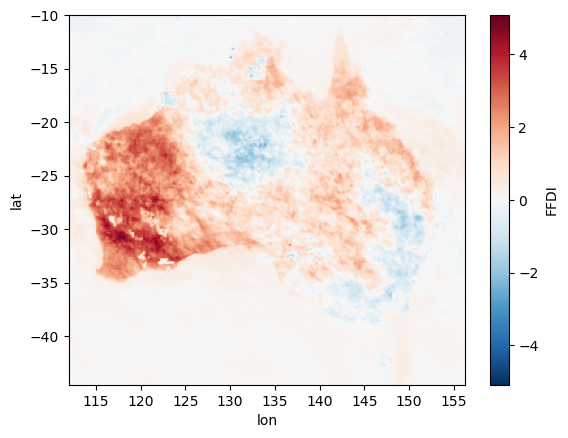

In [38]:
diff.FFDI.mean('time').plot()

In [1]:
client.close()

NameError: name 'client' is not defined